# DRL Portfolio Optimization


### Acknowledgements
This workbook is the culmination of three separate half credit independent studies by the author [Daniel Fudge](https://www.linkedin.com/in/daniel-fudge) with [Professor Yelena Larkin](https://www.linkedin.com/in/yelena-larkin-6b7b361b/) 
as part of a concurrent Master of Business Administration (MBA) and a [Diploma in Financial Engineering](https://schulich.yorku.ca/programs/fnen/) from the [Schulich School of Business](https://schulich.yorku.ca/).  I wanted to thank Schulich and especially Professor Larkin for giving me the freedom to explorer the intersection of Machine Learning and Finance.   

I'd like to also mention the excellent training I recieved from [A Cloud Guru](https://acloud.guru/learn/aws-certified-machine-learning-specialty) to prepare for this project.  

This notebook takes much of the design and low level code from the AWS sample portfolio management [Notebook](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/reinforcement_learning/rl_portfolio_management_coach_customEnv), which inturn is based on Jiang, Zhengyao, Dixing Xu, and Jinjun Liang. "A deep reinforcement learning framework for the financial portfolio management problem." arXiv preprint arXiv:1706.10059 (2017).    

As detailed below, this notebook relies on the [RL Coach](https://github.com/NervanaSystems/coach#batch-reinforcement-learning) from Intel AI Labs, Apache [MXNet](https://mxnet.apache.org/) and OpenAI [Gym](https://gym.openai.com/).  All of which are amazing projects that I highly recommend investigating.

### Introduction

Now that we have the signals `signals.pkl` and prices `stock-data-clean.pkl` processed we can build the Reinforcement Learning algorithm.  The signals will be used to define the state of the market environment, called `observations` in the Gym documentation and `state` in other locations.  The prices will be used to generate the `rewards`.   

For a refresher on DRL I recommend looking through [report2](docs/report2.pdf) in this repo.  The basic RL feed back loop is shown below.    

![RL](docs/rl.png "Reinforcement Learning Loop")

Reinforcement Learning feedback loop.    
Image source: https://i.stack.imgur.com/eoeSq.png

### Action Space
The `action` space is simply vector containing the weights of the stocks in the portfolio.  Inside the environment these weights are limited to (0, 1) and an addition weight is added for the amount of cash in the portfolio.  The cash weight is simply one minus the sum of the other weights and also limited to (0, 1).  The last step is to normalize these weight so the sum is equal to 1.0.

### State (or Observation)
The `state` is simply the signals we compiled in the previous data preparation [notebook](docs/data-preparation-no-memory.ipynb) including a time embbeding called the `window_length` within the code.  Instead of using the LSTM discussed previously, we are using a short Convolutional Neural Net (CNN) to capture some historical information from the data within the `agent`.

### Agent
For the agent we are using the [RL Coach](https://github.com/NervanaSystems/coach#batch-reinforcement-learning) from Intel AI Labs that is integrated into AWS [Sagemaker](https://docs.aws.amazon.com/sagemaker/latest/dg/reinforcement-learning.html#sagemaker-rl).  As you can see below there are a large number of RL algorithms to choose from.  In  [report2](docs/report2.pdf) we discussed serval of these and focused on the Deep Deterministic Policy Gradient (DDPG) Actor-Critic method however for this test we are trying the Proximal Policy Optimization (PPO) algorithm that is explained nicely by Jonathan Hui [here](https://medium.com/@jonathan_hui/rl-proximal-policy-optimization-ppo-explained-77f014ec3f12) and the original paper by Schulman et al. [here](https://arxiv.org/pdf/1707.06347.pdf).    

Remember that the goal of the agent is to learn a policy that maximizes the sum of discounted rewards, which in our case will result in the maximization of the portfolio value.

![Coach](docs/rl-coach.png)
RL Coach Algorithms
Imafe Source:  https://github.com/NervanaSystems/coach#batch-reinforcement-learning

#### Tweaks to Agent
If you are playing with the number of signals you may have to change the input to the Agent.  Unfortunately one of the disadvantages of using pre-built frameworks is the extra overhead and the difficulity finding the little details you need to tweak.   

Here we have to define input, which for us is a 2D CNN or Conv2D as a RL Coach [input embedder](https://nervanasystems.github.io/coach/design/network.html) but it is actually passed to the Conv2D within Apache [MXNet].   The RL Coach [code](https://github.com/NervanaSystems/coach/blob/master/rl_coach/architectures/layers.py) that passes the arguments to the MXNet Conv2D [code](https://beta.mxnet.io/api/gluon/_autogen/mxnet.gluon.nn.Conv2D.html) only accepts the 3 arguments and the MXNet infers the rest.  This lack of control makes setting up the problem a little tricky.  Also for time series data the MXNet [Conv1D](https://beta.mxnet.io/api/gluon/_autogen/mxnet.gluon.nn.Conv1D.html) would be more appropriate but RL coach doesn't give us the flexibility.    

The interface to RL Coach is defined in `preset-portfolio-management-clippedppo.py` shown below.  The line you may want to tweak is under "Agent" and contains the Conv2D argument.  This needs to coorespond to the observation space definition and how the observation is pulled from the signals in the `portfolio_env.py` file shown below as well.  Both of these are in the `src` folder.

In [1]:
!pygmentize src/preset-portfolio-management-clippedppo.py

from rl_coach.agents.clipped_ppo_agent import ClippedPPOAgentParameters
from rl_coach.architectures.layers import Dense, Conv2d
from rl_coach.base_parameters import VisualizationParameters, PresetValidationParameters
from rl_coach.base_parameters import MiddlewareScheme, DistributedCoachSynchronizationType
from rl_coach.core_types import TrainingSteps, EnvironmentEpisodes, EnvironmentSteps, RunPhase
from rl_coach.environments.gym_environment import GymVectorEnvironment, ObservationSpaceType
from rl_coach.exploration_policies.e_greedy import EGreedyParameters
from rl_coach.graph_managers.basic_rl_graph_manager import BasicRLGraphManager
from rl_coach.graph_managers.graph_manager import ScheduleParameters
from rl_coach.schedules import LinearSchedule

####################
# Graph Scheduling #
####################

schedule_params = ScheduleParameters()
schedule_params.improve_steps = TrainingSteps(20000)
schedule_params.steps_between_evaluation_periods = EnvironmentSteps(2048)
schedule_p

### Environment
This leaves us with the environment to generate.  Here we build a custom finacial market environment (or simulator) based on the signals and prices we compiled previously on top of the OpenAI [Gym](https://gym.openai.com/), which is also integrated into AWS [Sagemaker](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-rl-environments.html#sagemaker-rl-environments-gym).  This takes care of the low level integration allows us to focus on the features of the environment specific to portfolio optimization.   

During each training epoch, the trainer randomly selects a date to start.  It then steps through each day in the epoch and following these high level operations.
1. Initialze the state from the signals with the randomly selected start date and sets the portfolio to $1 of cash.
1. Pass the state to the agent who generates an action, which is a new set of desired portfolio weights.
1. Pass the new weigths (action) to the environment who calculates: 
  * The new portfolio value based on changes in the prices, weights and transaction costs.   
  * The reward based on the previous weights and the change in prices.
  * The new state, which is simply pulled from the signals dataset.
1. Pass the new reward and state to the agent, who must then learn to make a better action. 

#### Custom Portfolio Environment
The code below implements the custom financial market environment that the agent must trade in.

In [2]:
!pygmentize src/portfolio_env.py

""" Modified from https://github.com/awslabs/amazon-sagemaker-examples """

import gym
import gym.spaces
import os
import numpy as np
import pandas as pd

EPS = 1e-8


class PortfolioEnv(gym.Env):
    """ This class creates the financial market environment that the Agent interact with.

    It extends the OpenAI Gym environment https://gym.openai.com/.

    More information of how it is integrated into AWS is found here
    https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-rl-environments.html#sagemaker-rl-environments-gym

    The observations include a history of the signals with the given `window_length` ending at the current date.

    Args:
        steps (int):  Steps or days in an episode.
        trading_cost (float):  Cost of trade as a fraction.
        window_length (int):  How many past observations to return.
        start_date_index (int):  The date index in the signals and price arrays.

    Attributes:
        action_space (gym.spaces.Box):  [n_tickers]  The port

## Setup
### Roles and permissions

To get started, we'll import the Python libraries we need, set up the environment with a few prerequisites for permissions and configurations.

In [3]:
import boto3
import glob
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import sagemaker
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework
from src.misc import get_execution_role, wait_for_s3_object
import sys
import subprocess
import time
from time import gmtime, strftime
sys.path.append("common")
%matplotlib inline

### Setup S3 buckets

Set up the linkage and authentication to the S3 bucket that you want to use for checkpoint and the metadata. 

In [4]:
sage_session = sagemaker.session.Session()
s3_bucket = sage_session.default_bucket()  
s3_output_path = 's3://{}/'.format(s3_bucket)
checkpoint_path = s3_output_path[:-1] + '/checkpoints'
print("Checkpoint s3 path: {}".format(checkpoint_path))

Checkpoint s3 path: s3://sagemaker-us-east-1-031118886020/checkpoints


### Create an IAM role
Get the execution IAM role that allows this notebook to connect to the training and evaluation instances.

In [5]:
role = sagemaker.get_execution_role()
print("Using IAM role arn: {}".format(role))

Using IAM role arn: arn:aws:iam::031118886020:role/sagemaker


## Train the RL model using the Python SDK Script mode

1. Specify the source directory where the environment, presets and training code is uploaded, `src`.
2. Specify the `entry_point` as the training code,  
3. Specify the choice of RL `toolkit` and framework. This automatically resolves to the ECR path for the RL Container. 
4. Define the training parameters such as the instance count, job name, S3 path for output and job name. 
5. Specify the hyperparameters for the RL agent algorithm. The `RLCOACH_PRESET` can be used to specify the RL agent algorithm you want to use. 
6. [Optional] Choose the metrics that you are interested in capturing in your logs. These can also be visualized in CloudWatch and SageMaker Notebooks. The metrics are defined using regular expression matching.


#### Price reference
Here are some price data for reference.  Obviously these values will change as you change the hyperparameters and model architecture.  Please check the pricing [list](https://aws.amazon.com/sagemaker/pricing/) for the latest pricing and instance types.
- **ml.c4.xlarge:**   $423s =  7.1 min = 0.118 hr \rightarrow \$0.03 = 0.118 hr \cdot 0.279 \frac{\$}{hr} $ 
- **ml.c4.2xlarge:**  $371s =  6.2 min = 0.103 hr \rightarrow \$0.06 = 0.103 hr \cdot 0.557 \frac{\$}{hr} $ 
- **ml.c4.4xlarge:**  $380s =  6.3 min = 0.106 hr \rightarrow \$0.12 = 0.106 hr \cdot 1.114 \frac{\$}{hr} $ 
- **ml.c4.8xlarge:**  $390s =  6.5 min = 0.108 hr \rightarrow \$0.24 = 0.108 hr \cdot 2.227 \frac{\$}{hr} $ 
- **ml.m4.4xlarge:**  $414s =  6.9 min = 0.115 hr \rightarrow \$0.13 = 0.115 hr \cdot 1.12 \frac{\$}{hr} $ 
- **ml.p3.2xlarge:**  $558s =  9.3 min = 0.155 hr \rightarrow \$0.66 = 0.155 hr \cdot 4.284 \frac{\$}{hr}$
- **ml.p2.xlarge:**   $713s = 11.9 min = 0.198 hr \rightarrow \$0.25 = 0.198 hr \cdot 1.26 \frac{\$}{hr}$

In [6]:
instance_type = "ml.c4.2xlarge"

In [7]:
# Set this to false to start training from scratch
rerun = False

2020-03-29 06:12:10 Starting - Starting the training job...
2020-03-29 06:12:13 Starting - Launching requested ML instances.........
2020-03-29 06:13:45 Starting - Preparing the instances for training......
2020-03-29 06:15:05 Downloading - Downloading input data
2020-03-29 06:15:05 Training - Downloading the training image...
2020-03-29 06:15:25 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-03-29 06:15:27,601 sagemaker-containers INFO     Imported framework sagemaker_mxnet_container.training
2020-03-29 06:15:27,604 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-03-29 06:15:27,617 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HPS': '{"RLCOACH_PRESET":"preset-portfolio-management-clippedppo","improve_steps":100000,"rl.agent_params.algorithm.discount":0.9,"rl.evaluation_steps:Environment

Testing> Name=main_level/agent, Worker=0, Episode=4, Total reward=-0.46, Steps=2048, Training iteration=0
Testing> Name=main_level/agent, Worker=0, Episode=4, Total reward=-0.42, Steps=2048, Training iteration=0
Testing> Name=main_level/agent, Worker=0, Episode=4, Total reward=-0.33, Steps=2048, Training iteration=0
## agent: Finished evaluation phase. Success rate = 0.0, Avg Total Reward = -0.42
Training> Name=main_level/agent, Worker=0, Episode=5, Total reward=-0.92, Steps=2554, Training iteration=0
/usr/local/lib/python3.5/dist-packages/rl_coach/architectures/mxnet_components/heads/head.py:95: UserWarning: Parameter clippedppolosscontinuous0_kl_coefficient is not used by any computation. Is this intended?
  outputs = super(HeadLoss, self).forward(*args)
Policy training> Surrogate loss=-0.010547440499067307, KL divergence=[0.], Entropy=[-0.14192474], training epoch=0, learning_rate=0.0001
Policy training> Surrogate loss=-0.0327768549323082, KL divergence=[0.], Entropy=[-0.1419121], t

Policy training> Surrogate loss=-0.02623504027724266, KL divergence=[0.], Entropy=[-0.14161673], training epoch=9, learning_rate=0.0001
Checkpoint> Saving in path=['/opt/ml/output/data/checkpoint/3_Step-8698.ckpt.main_level.agent.main.online']
Training> Name=main_level/agent, Worker=0, Episode=18, Total reward=-1.37, Steps=9204, Training iteration=4
Training> Name=main_level/agent, Worker=0, Episode=19, Total reward=-1.69, Steps=9710, Training iteration=4
Training> Name=main_level/agent, Worker=0, Episode=20, Total reward=-1.54, Steps=10216, Training iteration=4
## agent: Starting evaluation phase
Testing> Name=main_level/agent, Worker=0, Episode=20, Total reward=0.14, Steps=10240, Training iteration=4
Testing> Name=main_level/agent, Worker=0, Episode=20, Total reward=0.02, Steps=10240, Training iteration=4
Testing> Name=main_level/agent, Worker=0, Episode=20, Total reward=-0.04, Steps=10240, Training iteration=4
Testing> Name=main_level/agent, Worker=0, Episode=20, Total reward=-0.03,

Policy training> Surrogate loss=-0.007005932275205851, KL divergence=[0.], Entropy=[-0.14201722], training epoch=2, learning_rate=0.0001
Policy training> Surrogate loss=-0.003621792420744896, KL divergence=[0.], Entropy=[-0.14203246], training epoch=3, learning_rate=0.0001
Policy training> Surrogate loss=-0.019075430929660797, KL divergence=[0.], Entropy=[-0.14203113], training epoch=4, learning_rate=0.0001
Policy training> Surrogate loss=-0.021277550607919693, KL divergence=[0.], Entropy=[-0.14203559], training epoch=5, learning_rate=0.0001
Policy training> Surrogate loss=-0.014605460688471794, KL divergence=[0.], Entropy=[-0.14204189], training epoch=6, learning_rate=0.0001
Policy training> Surrogate loss=-0.026040339842438698, KL divergence=[0.], Entropy=[-0.14204447], training epoch=7, learning_rate=0.0001
Policy training> Surrogate loss=-0.020529912784695625, KL divergence=[0.], Entropy=[-0.14205414], training epoch=8, learning_rate=0.0001
Policy training> Surrogate loss=-0.021286

Testing> Name=main_level/agent, Worker=0, Episode=48, Total reward=0.51, Steps=24576, Training iteration=11
Testing> Name=main_level/agent, Worker=0, Episode=48, Total reward=0.59, Steps=24576, Training iteration=11
Testing> Name=main_level/agent, Worker=0, Episode=48, Total reward=0.52, Steps=24576, Training iteration=11
## agent: Finished evaluation phase. Success rate = 0.0, Avg Total Reward = 0.52
Training> Name=main_level/agent, Worker=0, Episode=49, Total reward=-1.2, Steps=25082, Training iteration=11
Policy training> Surrogate loss=0.001983839785680175, KL divergence=[0.], Entropy=[-0.14214613], training epoch=0, learning_rate=0.0001
Policy training> Surrogate loss=-0.004103517159819603, KL divergence=[0.], Entropy=[-0.14214794], training epoch=1, learning_rate=0.0001
Policy training> Surrogate loss=-0.01275541540235281, KL divergence=[0.], Entropy=[-0.14214599], training epoch=2, learning_rate=0.0001
Policy training> Surrogate loss=-0.014273268170654774, KL divergence=[0.], En

Training> Name=main_level/agent, Worker=0, Episode=62, Total reward=-1.28, Steps=31732, Training iteration=15
Training> Name=main_level/agent, Worker=0, Episode=63, Total reward=-0.94, Steps=32238, Training iteration=15
Training> Name=main_level/agent, Worker=0, Episode=64, Total reward=-0.84, Steps=32744, Training iteration=15
## agent: Starting evaluation phase
Testing> Name=main_level/agent, Worker=0, Episode=64, Total reward=0.68, Steps=32768, Training iteration=15
Testing> Name=main_level/agent, Worker=0, Episode=64, Total reward=0.73, Steps=32768, Training iteration=15
Testing> Name=main_level/agent, Worker=0, Episode=64, Total reward=0.73, Steps=32768, Training iteration=15
Testing> Name=main_level/agent, Worker=0, Episode=64, Total reward=0.81, Steps=32768, Training iteration=15
Testing> Name=main_level/agent, Worker=0, Episode=64, Total reward=0.59, Steps=32768, Training iteration=15
## agent: Finished evaluation phase. Success rate = 0.0, Avg Total Reward = 0.71
Training> Nam

Policy training> Surrogate loss=-0.013153470121324062, KL divergence=[0.], Entropy=[-0.14230737], training epoch=3, learning_rate=0.0001
Policy training> Surrogate loss=-0.012171844951808453, KL divergence=[0.], Entropy=[-0.14229532], training epoch=4, learning_rate=0.0001
Policy training> Surrogate loss=-0.009883696213364601, KL divergence=[0.], Entropy=[-0.14228271], training epoch=5, learning_rate=0.0001
Policy training> Surrogate loss=-0.018662920221686363, KL divergence=[0.], Entropy=[-0.14227077], training epoch=6, learning_rate=0.0001
Policy training> Surrogate loss=-0.017675038427114487, KL divergence=[0.], Entropy=[-0.1422619], training epoch=7, learning_rate=0.0001
Policy training> Surrogate loss=-0.021134329959750175, KL divergence=[0.], Entropy=[-0.14225079], training epoch=8, learning_rate=0.0001
Policy training> Surrogate loss=-0.01719995029270649, KL divergence=[0.], Entropy=[-0.14223252], training epoch=9, learning_rate=0.0001
Checkpoint> Saving in path=['/opt/ml/output

Testing> Name=main_level/agent, Worker=0, Episode=92, Total reward=1.36, Steps=47104, Training iteration=22
Testing> Name=main_level/agent, Worker=0, Episode=92, Total reward=1.35, Steps=47104, Training iteration=22
## agent: Finished evaluation phase. Success rate = 0.0, Avg Total Reward = 1.29
Training> Name=main_level/agent, Worker=0, Episode=93, Total reward=-1.1, Steps=47610, Training iteration=22
Policy training> Surrogate loss=0.00314492080360651, KL divergence=[0.], Entropy=[-0.1422726], training epoch=0, learning_rate=0.0001
Policy training> Surrogate loss=-0.004309006500989199, KL divergence=[0.], Entropy=[-0.14229551], training epoch=1, learning_rate=0.0001
Policy training> Surrogate loss=-0.002759566530585289, KL divergence=[0.], Entropy=[-0.14229871], training epoch=2, learning_rate=0.0001
Policy training> Surrogate loss=-0.008709232322871685, KL divergence=[0.], Entropy=[-0.14230798], training epoch=3, learning_rate=0.0001
Policy training> Surrogate loss=-0.00632923515513

Policy training> Surrogate loss=-0.0028276911471039057, KL divergence=[0.], Entropy=[-0.14246039], training epoch=0, learning_rate=0.0001
Policy training> Surrogate loss=-0.005137464497238398, KL divergence=[0.], Entropy=[-0.14247449], training epoch=1, learning_rate=0.0001
Policy training> Surrogate loss=-0.01059898640960455, KL divergence=[0.], Entropy=[-0.14246121], training epoch=2, learning_rate=0.0001
Policy training> Surrogate loss=-0.002816257532685995, KL divergence=[0.], Entropy=[-0.14245757], training epoch=3, learning_rate=0.0001
Policy training> Surrogate loss=-0.006480109412223101, KL divergence=[0.], Entropy=[-0.1424505], training epoch=4, learning_rate=0.0001
Policy training> Surrogate loss=-0.014662773348391056, KL divergence=[0.], Entropy=[-0.1424432], training epoch=5, learning_rate=0.0001
Policy training> Surrogate loss=-0.006662333384156227, KL divergence=[0.], Entropy=[-0.14243408], training epoch=6, learning_rate=0.0001
Policy training> Surrogate loss=-0.01724442

Testing> Name=main_level/agent, Worker=0, Episode=120, Total reward=1.55, Steps=61440, Training iteration=29
Testing> Name=main_level/agent, Worker=0, Episode=120, Total reward=1.41, Steps=61440, Training iteration=29
Testing> Name=main_level/agent, Worker=0, Episode=120, Total reward=1.53, Steps=61440, Training iteration=29
Testing> Name=main_level/agent, Worker=0, Episode=120, Total reward=1.54, Steps=61440, Training iteration=29
## agent: Finished evaluation phase. Success rate = 0.0, Avg Total Reward = 1.51
Training> Name=main_level/agent, Worker=0, Episode=121, Total reward=-0.79, Steps=61946, Training iteration=29
Policy training> Surrogate loss=0.003128254320472479, KL divergence=[0.], Entropy=[-0.14255458], training epoch=0, learning_rate=0.0001
Policy training> Surrogate loss=0.0007790644303895533, KL divergence=[0.], Entropy=[-0.14254074], training epoch=1, learning_rate=0.0001
Policy training> Surrogate loss=-0.0019689586479216814, KL divergence=[0.], Entropy=[-0.14255063], 

Policy training> Surrogate loss=0.005412551574409008, KL divergence=[0.], Entropy=[-0.14256948], training epoch=9, learning_rate=0.0001
Checkpoint> Saving in path=['/opt/ml/output/data/checkpoint/32_Step-68090.ckpt.main_level.agent.main.online']
Training> Name=main_level/agent, Worker=0, Episode=134, Total reward=-0.73, Steps=68596, Training iteration=33
Training> Name=main_level/agent, Worker=0, Episode=135, Total reward=-0.85, Steps=69102, Training iteration=33
Training> Name=main_level/agent, Worker=0, Episode=136, Total reward=-1.12, Steps=69608, Training iteration=33
## agent: Starting evaluation phase
Testing> Name=main_level/agent, Worker=0, Episode=136, Total reward=1.61, Steps=69632, Training iteration=33
Testing> Name=main_level/agent, Worker=0, Episode=136, Total reward=1.66, Steps=69632, Training iteration=33
Testing> Name=main_level/agent, Worker=0, Episode=136, Total reward=1.61, Steps=69632, Training iteration=33
Testing> Name=main_level/agent, Worker=0, Episode=136, Tot

Policy training> Surrogate loss=0.0037267920561134815, KL divergence=[0.], Entropy=[-0.1426698], training epoch=1, learning_rate=0.0001
Policy training> Surrogate loss=0.0006737239309586585, KL divergence=[0.], Entropy=[-0.14269388], training epoch=2, learning_rate=0.0001
Policy training> Surrogate loss=0.003821284044533968, KL divergence=[0.], Entropy=[-0.14268233], training epoch=3, learning_rate=0.0001
Policy training> Surrogate loss=0.0014837234048172832, KL divergence=[0.], Entropy=[-0.14269613], training epoch=4, learning_rate=0.0001
Policy training> Surrogate loss=-0.0009913871763274074, KL divergence=[0.], Entropy=[-0.14270268], training epoch=5, learning_rate=0.0001
Policy training> Surrogate loss=0.0032081666868180037, KL divergence=[0.], Entropy=[-0.14269763], training epoch=6, learning_rate=0.0001
Policy training> Surrogate loss=0.0005074032815173268, KL divergence=[0.], Entropy=[-0.14269346], training epoch=7, learning_rate=0.0001
Policy training> Surrogate loss=0.00254014

Testing> Name=main_level/agent, Worker=0, Episode=164, Total reward=1.7, Steps=83968, Training iteration=40
Testing> Name=main_level/agent, Worker=0, Episode=164, Total reward=1.75, Steps=83968, Training iteration=40
Testing> Name=main_level/agent, Worker=0, Episode=164, Total reward=1.73, Steps=83968, Training iteration=40
Testing> Name=main_level/agent, Worker=0, Episode=164, Total reward=1.69, Steps=83968, Training iteration=40
## agent: Finished evaluation phase. Success rate = 0.0, Avg Total Reward = 1.71
Training> Name=main_level/agent, Worker=0, Episode=165, Total reward=-0.72, Steps=84474, Training iteration=40
Policy training> Surrogate loss=0.0015688021667301655, KL divergence=[0.], Entropy=[-0.14281313], training epoch=0, learning_rate=0.0001
Policy training> Surrogate loss=0.010398644022643566, KL divergence=[0.], Entropy=[-0.14283787], training epoch=1, learning_rate=0.0001
Policy training> Surrogate loss=0.0006094666314311326, KL divergence=[0.], Entropy=[-0.14284046], tr

Policy training> Surrogate loss=0.007456258404999971, KL divergence=[0.], Entropy=[-0.14298852], training epoch=9, learning_rate=0.0001
Checkpoint> Saving in path=['/opt/ml/output/data/checkpoint/43_Step-90618.ckpt.main_level.agent.main.online']
Training> Name=main_level/agent, Worker=0, Episode=178, Total reward=-1.12, Steps=91124, Training iteration=44
Training> Name=main_level/agent, Worker=0, Episode=179, Total reward=-0.85, Steps=91630, Training iteration=44
Training> Name=main_level/agent, Worker=0, Episode=180, Total reward=-0.82, Steps=92136, Training iteration=44
## agent: Starting evaluation phase
Testing> Name=main_level/agent, Worker=0, Episode=180, Total reward=1.7, Steps=92160, Training iteration=44
Testing> Name=main_level/agent, Worker=0, Episode=180, Total reward=1.75, Steps=92160, Training iteration=44
Testing> Name=main_level/agent, Worker=0, Episode=180, Total reward=1.73, Steps=92160, Training iteration=44
Testing> Name=main_level/agent, Worker=0, Episode=180, Tota

Policy training> Surrogate loss=0.00681733526289463, KL divergence=[0.], Entropy=[-0.14313146], training epoch=0, learning_rate=0.0001
Policy training> Surrogate loss=0.0023761752527207136, KL divergence=[0.], Entropy=[-0.14313105], training epoch=1, learning_rate=0.0001
Policy training> Surrogate loss=-0.0020642364397644997, KL divergence=[0.], Entropy=[-0.14314283], training epoch=2, learning_rate=0.0001
Policy training> Surrogate loss=0.0035560810938477516, KL divergence=[0.], Entropy=[-0.14313538], training epoch=3, learning_rate=0.0001
Policy training> Surrogate loss=0.001221068436279893, KL divergence=[0.], Entropy=[-0.14315224], training epoch=4, learning_rate=0.0001
Policy training> Surrogate loss=-0.0014157358091324568, KL divergence=[0.], Entropy=[-0.14313838], training epoch=5, learning_rate=0.0001
Policy training> Surrogate loss=-0.0037839969154447317, KL divergence=[0.], Entropy=[-0.14314829], training epoch=6, learning_rate=0.0001
Policy training> Surrogate loss=-0.001277

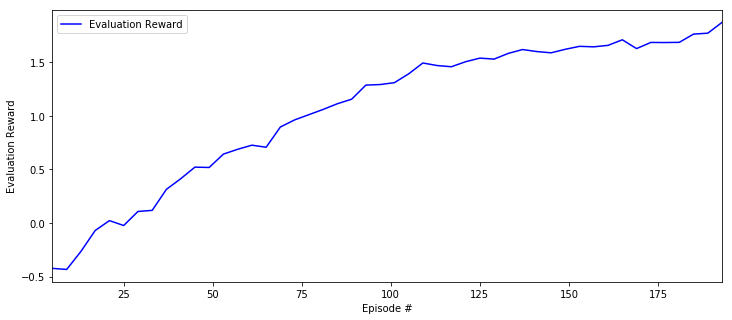

In [8]:
# First define the Reinforcement Learning Estimator
job_name_prefix = 'drl-portfolio-optimization'
estimator = RLEstimator(source_dir='src',
                        entry_point="train-coach.py",
                        dependencies=["common/sagemaker_rl"],
                        toolkit=RLToolkit.COACH,
                        toolkit_version='0.11.0',
                        framework=RLFramework.MXNET,
                        role=role,
                        train_instance_count=1,
                        train_instance_type=instance_type,
                        output_path=s3_output_path,
                        base_job_name=job_name_prefix,
                        hyperparameters = {
                            "RLCOACH_PRESET" : "preset-portfolio-management-clippedppo",
                            "rl.agent_params.algorithm.discount": 0.9,
                            "rl.evaluation_steps:EnvironmentEpisodes": 5,
                            "training_epochs": 10,
                            "improve_steps":100000})

# Perform the training
if rerun:
    estimator.fit({'checkpoint': checkpoint_path})
else:
    estimator.fit()
    
# Bring the training output back to the Sagemaker instance
job_name=estimator._current_job_name
print("\nJob name: {}\n".format(job_name))

output_tar_key = "{}/output/output.tar.gz".format(job_name)
intermediate_folder_key = "{}/output/intermediate/".format(job_name)
intermediate_url = "s3://{}/{}".format(s3_bucket, intermediate_folder_key)
tmp_dir = "/tmp/{}".format(job_name)
local_checkpoint_path = tmp_dir + '/checkpoint'
os.system("mkdir {}".format(tmp_dir))
wait_for_s3_object(s3_bucket, output_tar_key, tmp_dir)  
os.system("tar -xvzf {}/output.tar.gz -C {}".format(tmp_dir, tmp_dir))
os.system("aws s3 cp --recursive {} {}".format(intermediate_url, tmp_dir))
os.system("tar -xvzf {}/output.tar.gz -C {}".format(tmp_dir, tmp_dir))
print("\nCopied output files to 'tmp_dir': {}\n".format(tmp_dir))


# Plot the training history
csv_file_name = "worker_0.simple_rl_graph.main_level.main_level.agent_0.csv"
wait_for_s3_object(s3_bucket, os.path.join(intermediate_folder_key, csv_file_name), tmp_dir)

df = pd.read_csv("{}/{}".format(tmp_dir, csv_file_name))
df = df.dropna(subset=['Evaluation Reward'])
x_axis = 'Episode #'
y_axis = 'Evaluation Reward'

plt = df.plot(x=x_axis,y=y_axis, figsize=(12,5), legend=True, style='b-')
plt.set_ylabel(y_axis);
plt.set_xlabel(x_axis);

rerun = True

## Run the Policy through the Test Data


#### Run the evaluation on the test data
Note the major differences from the training step above is the 2 year `evaluate_steps` hyperparameter, the `evaluate-coach.py` vs `train-coach.py` entry point and the `checkpoint` argument passed to the fit function.  At the start of the entry point script, the training or test dataset are selected ensuring there is no data leakage from the training into the test.

In [9]:
local_checkpoint_path = tmp_dir + '/checkpoint'
s3_checkpoint_path = "s3://{}/{}/checkpoint/".format(s3_bucket, job_name)
os.system("aws s3 cp --recursive {} {}".format(local_checkpoint_path, s3_checkpoint_path))
print('src:  ' + local_checkpoint_path)
print('dst:  ' + s3_checkpoint_path)

src:  /tmp/drl-portfolio-optimization-2020-03-29-06-12-09-827/checkpoint
dst:  s3://sagemaker-us-east-1-031118886020/drl-portfolio-optimization-2020-03-29-06-12-09-827/checkpoint/


2020-03-29 06:26:02 Starting - Starting the training job...
2020-03-29 06:26:05 Starting - Launching requested ML instances............
2020-03-29 06:28:15 Starting - Preparing the instances for training...
2020-03-29 06:28:57 Downloading - Downloading input data...
2020-03-29 06:29:31 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-03-29 06:29:32,650 sagemaker-containers INFO     Imported framework sagemaker_mxnet_container.training
2020-03-29 06:29:32,653 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-03-29 06:29:32,665 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HPS': '{"evaluate_steps":506}', 'SM_USER_ENTRY_POINT': 'evaluate-coach.py', 'SM_MODULE_DIR': 's3://sagemaker-us-east-1-031118886020/sagemaker-rl-mxnet-2020-03-29-06-26-01-782/source/sourcedir.tar.gz', 'SM_INPUT_DATA_CONFIG'

Testing> Name=main_level/agent, Worker=0, Episode=1, Total reward=1.89, Steps=506, Training iteration=0
## agent: Finished evaluation phase. Success rate = 0.0, Avg Total Reward = 1.89
2020-03-29 06:29:38,172 sagemaker-containers INFO     Reporting training SUCCESS

2020-03-29 06:29:49 Uploading - Uploading generated training model
2020-03-29 06:29:49 Completed - Training job completed
Training seconds: 52
Billable seconds: 52
Waiting for s3://sagemaker-us-east-1-031118886020/sagemaker-rl-mxnet-2020-03-29-06-26-01-782/output/output.tar.gz...

Copied output files to /tmp/sagemaker-rl-mxnet-2020-03-29-06-26-01-782



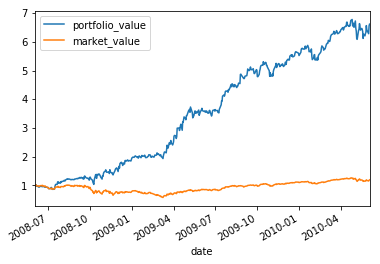

In [10]:
# Define the RL estimator
estimator = RLEstimator(role=role,
                        source_dir='src/',
                        dependencies=["common/sagemaker_rl"],
                        toolkit=RLToolkit.COACH,
                        toolkit_version='0.11.0',
                        framework=RLFramework.MXNET,
                        entry_point="evaluate-coach.py",
                        train_instance_count=1,
                        train_instance_type=instance_type,
                        hyperparameters = {"evaluate_steps": 253*2})

# Perform the evaluation
estimator.fit({'checkpoint': s3_checkpoint_path})

# Get the data from S3
job_name=estimator._current_job_name
output_tar_key = "{}/output/output.tar.gz".format(job_name)
intermediate_folder_key = "{}/output/intermediate/".format(job_name)
intermediate_url = "s3://{}/{}".format(s3_bucket, intermediate_folder_key)
tmp_dir = "/tmp/{}".format(job_name)
os.system("mkdir {}".format(tmp_dir))

wait_for_s3_object(s3_bucket, output_tar_key, tmp_dir)  
os.system("tar -xvzf {}/output.tar.gz -C {}".format(tmp_dir, tmp_dir))
os.system("aws s3 cp --recursive {} {}".format(intermediate_url, tmp_dir))
os.system("tar -xvzf {}/output.tar.gz -C {}".format(tmp_dir, tmp_dir))
print("\nCopied output files to {}\n".format(tmp_dir))

# Plot the RL Policy performance against a buy and hold policy
df_info = pd.read_csv(tmp_dir + '/portfolio-management.csv')
df_info['date'] = pd.to_datetime(df_info['date'], format='%Y-%m-%d')
df_info.set_index('date', inplace=True)
df_info[["portfolio_value", "market_value"]].plot(rot=30)